In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models


In [7]:
data_dir = pathlib.Path('../input/train')

commands = np.array(tf.io.gfile.listdir(str(data_dir)))


In [8]:
commands

array(['machine02', 'machine01', 'machine10', 'machine11', 'machine15',
       'machine14', 'machine07', 'machine05', 'machine13', '.DS_Store',
       'machine04', 'machine06', 'machine16', 'machine08', 'machine03',
       'machine09', 'machine12'], dtype='<U9')

In [17]:
filenames = tf.io.gfile.glob(str(data_dir)+'/*/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("Number of total examples:", num_samples)


Number of total examples: 3308


In [20]:
train_files = filenames[:2708]
val_files = filenames[2708: 2708+300]
test_files = filenames[-300:]



In [24]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=1)


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label


In [25]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)


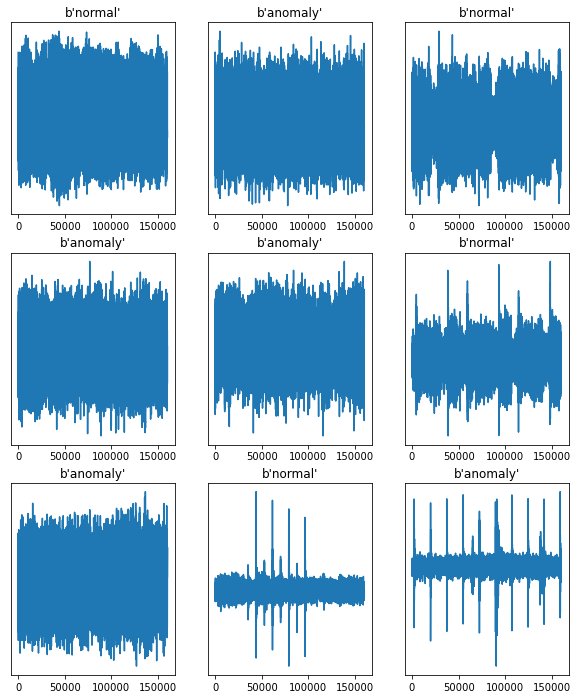

In [27]:
rows = 3
cols = 3

n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10,12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r = i //cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-0.1, 0.1))
    label = label.numpy()
    ax.set_title(label)



In [28]:
waveform_ds.take(0)

<TakeDataset shapes: ((None,), ()), types: (tf.float32, tf.string)>

In [29]:
def get_spectorgram(waveform):
    zero_padding = tf.zeros([160000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
        equal_length, frame_length = 255, frame_step=128
    )

    spectrogram = tf.abs(spectrogram)

    return spectrogram


In [30]:
for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectorgram(waveform)

print("Label:", label)
print("Waveform shape:", waveform.shape)
print("Spectrogram shape", spectrogram.shape)


Label: normal
Waveform shape: (160000,)
Spectrogram shape (1249, 129)


TypeError: Dimensions of C (129, 1249) are incompatible with X (129) and/or Y (1231); see help(pcolormesh)

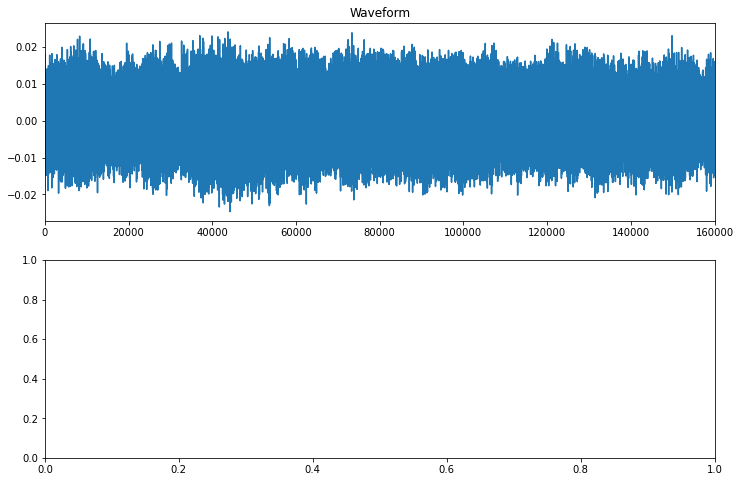

In [32]:
def plot_spectrogram(spectrogram, ax):
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    X = np.arange(160000, step=height+1)
    Y = range(height)
    ax.pcolormesh(Y, X, log_spec)


fig, axes = plt.subplots(2, figsize=(12,8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title("Waveform")
axes[0].set_xlim([0, 160000])
plot_spectrogram(spectrogram.numpy(), axes[1])


In [58]:
sta = np.array(['normal', 'anomaly'])
sta = {'normal':1, 'anomaly':0}

def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectorgram(audio)
    
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label==sta)

    return spectrogram, label_id


In [59]:
spectrogram_ds = waveform_ds.map(get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)


TypeError: in user code:

    <ipython-input-38-044eadcfdab4>:8 get_spectrogram_and_label_id  *
        label_id = tf.argmax(label==sta)
    /home/ma/.bin/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/ops/math_ops.py:1491 tensor_equals
        return gen_math_ops.equal(self, other, incompatible_shape_error=False)
    /home/ma/.bin/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/ops/gen_math_ops.py:3222 equal
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /home/ma/.bin/anaconda3/envs/tensor/lib/python3.8/site-packages/tensorflow/python/framework/op_def_library.py:475 _apply_op_helper
        raise TypeError(

    TypeError: Expected string passed to parameter 'y' of op 'Equal', got {'normal': 1, 'anomaly': 0} of type 'dict' instead. Error: Expected string, got 0 of type 'int' instead.


In [37]:
int(1)

1